<a href="https://colab.research.google.com/github/CD-AC/DataEnginner-ApacheSpark/blob/main/ApacheSpark_CosmeticsECommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data E-Commerce Cosmetics Shop

Proyecto de Análisis de Eventos de E-commerce con Apache Spark en Google Colab

Este notebook consolida todas las fases de un proyecto de análisis de datos
de eventos de e-commerce utilizando Apache Spark. Incluye la configuración del
entorno, descarga de datos de Kaggle, limpieza y preparación de datos,
análisis exploratorio, ingeniería de características, análisis avanzado
(segmentación de clientes con K-Means) y visualización de resultados.

# 1. CONFIGURACIÓN INICIAL DEL ENTORNO

In [3]:
# Instalar SDK Java 8
# La salida se redirige a /dev/null para mantener el notebook limpio
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
print("Java 8 instalado.")

# Descargamos Spark 3.4.3, Se descarga desde el archivo y se redirige la salida
!wget -q https://archive.apache.org/dist/spark/spark-3.4.3/spark-3.4.3-bin-hadoop3.tgz
print("Spark 3.4.3 descargado.")

# Descomprimir el archivo descargado de Spark
!tar xf spark-3.4.3-bin-hadoop3.tgz
print("Spark descomprimido.")

# Establecer las variables de entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.3-bin-hadoop3"
print("Variables de entorno SPARK_HOME y JAVA_HOME configuradas.")

# Instalar las librerías findspark y pyspark
!pip install -q findspark pyspark kagglehub matplotlib seaborn
print("findspark, pyspark, kagglehub, matplotlib y seaborn instalados.")

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, to_timestamp, lower, hour, dayofweek, month, year, min, max, countDistinct, when, avg, datediff, count, lead, row_number, to_date, dayofmonth, weekofyear, lag
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import kagglehub
import shutil

# Crear SparkSession, Se asigna una cantidad de memoria razonable al driver para manejar el dataset
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("EcommerceEventsAnalysis") \
    .config("spark.driver.memory", "16g") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

sc = spark.sparkContext
print("\nSpark Session creada exitosamente:")
spark

# Usar un directorio dentro del almacenamiento de la sesión de Colab
base_colab_path = "/content/spark_ecommerce_project"

# Crear directorios
os.makedirs(os.path.join(base_colab_path, "data/raw"), exist_ok=True)
os.makedirs(os.path.join(base_colab_path, "data/processed"), exist_ok=True)
os.makedirs(os.path.join(base_colab_path, "results/plots"), exist_ok=True)
print(f"Directorios de proyecto creados en: {base_colab_path}")

Java 8 instalado.
Spark 3.4.3 descargado.
Spark descomprimido.
Variables de entorno SPARK_HOME y JAVA_HOME configuradas.
findspark, pyspark, kagglehub, matplotlib y seaborn instalados.

Spark Session creada exitosamente:
Directorios de proyecto creados en: /content/spark_ecommerce_project


# 2. INGESTIÓN DE DATOS

In [4]:
# Usar kagglehub para descargar el dataset
print("Descargando dataset de Kaggle...")
try:
    path_to_zip = kagglehub.dataset_download("mkechinov/ecommerce-events-history-in-cosmetics-shop")
    print(f"Dataset descargado en: {path_to_zip}")

    # Descomprimir el dataset en el directorio de datos crudos en Colab
    raw_data_dir = os.path.join(base_colab_path, "data/raw")

    # Limpiar el directorio raw antes de descomprimir para evitar duplicados
    if os.path.exists(raw_data_dir) and os.path.isdir(raw_data_dir):
        shutil.rmtree(raw_data_dir)
    os.makedirs(raw_data_dir)

    # Verificamos si la ruta es un archivo o un directorio
    if os.path.isfile(path_to_zip) and str(path_to_zip).endswith('.zip'):
        print(f"Descomprimiendo {path_to_zip} en {raw_data_dir}...")
        shutil.unpack_archive(path_to_zip, raw_data_dir)
    elif os.path.isdir(path_to_zip):
        print(f"Copiando archivos de {path_to_zip} a {raw_data_dir}...")
        # Copiar todos los archivos CSV de la carpeta descargada a la carpeta raw_data_dir
        for item in os.listdir(path_to_zip):
            s = os.path.join(path_to_zip, item)
            d = os.path.join(raw_data_dir, item)
            if os.path.isfile(s):
                shutil.copy2(s, d)
        print("Archivos copiados.")
    else:
        print(f"La ruta de descarga no es un zip ni un directorio: {path_to_zip}.")

except Exception as e:
    print(f"Error al descargar o descomprimir el dataset: {e}")

# Ruta a los archivos CSV en el directorio raw_data_dir en Colab
csv_files_path = os.path.join(raw_data_dir, "*.csv")

# Cargar datos en un Spark DataFrame

try:
    df_raw = spark.read.csv(csv_files_path, header=True, inferSchema=True)
    print("\nDataFrame crudo cargado exitosamente.")
    print("Esquema del DataFrame crudo:")
    df_raw.printSchema()
    print(f"Número de registros en el DataFrame crudo: {df_raw.count()}")
    print("Primeras 5 filas del DataFrame crudo:")
    df_raw.show(5, truncate=False)

    # Guardar el DataFrame crudo en formato Parquet en Colab
    parquet_raw_path = os.path.join(base_colab_path, "data/processed/ecommerce_raw.parquet")
    df_raw.write.mode("overwrite").parquet(parquet_raw_path)
    print(f"\nDatos crudos guardados en formato Parquet en: {parquet_raw_path}")

except Exception as e:
    print(f"Error al cargar los datos en Spark: {e}")
    # Si falla la carga, podríamos cargar un dataset de prueba o salir
    print("No se pudo cargar el dataset.")
    spark.stop()
    exit()

Descargando dataset de Kaggle...
Dataset descargado en: /kaggle/input/ecommerce-events-history-in-cosmetics-shop
Copiando archivos de /kaggle/input/ecommerce-events-history-in-cosmetics-shop a /content/spark_ecommerce_project/data/raw...
Archivos copiados.

DataFrame crudo cargado exitosamente.
Esquema del DataFrame crudo:
root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)

Número de registros en el DataFrame crudo: 20692840
Primeras 5 filas del DataFrame crudo:
+-----------------------+----------------+----------+-------------------+-------------+---------+-----+---------+------------------------------------+
|event_time             |event_type      |product_id|cate

# 3. LIMPIEZA Y PREPARACIÓN DE DATOS

In [7]:
# Usar el directorio base en Colab para cargar y guardar archivos
base_colab_path = "/content/spark_ecommerce_project" # Asegurarse de que esta variable esté definida

# Cargar el DataFrame desde Parquet desde el almacenamiento de Colab
parquet_raw_path = os.path.join(base_colab_path, "data/processed/ecommerce_raw.parquet")
df = spark.read.parquet(parquet_raw_path)
print("DataFrame crudo cargado desde Parquet para limpieza.")

# Inspección y Manejo de Valores Faltantes
print("\nManejo de Valores Faltantes:")

# Contar valores nulos por columna
print("Conteo de valores nulos por columna:")
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

# Columnas críticas que no deberían tener nulos.
critical_columns = ["event_time", "event_type", "product_id", "category_id", "user_id", "user_session"]
df_cleaned = df.na.drop(subset=critical_columns)
print(f"Filas con valores nulos en columnas críticas ({', '.join(critical_columns)}) eliminadas.")

# Rellenar valores faltantes en 'brand' con 'unknown'
df_cleaned = df_cleaned.na.fill({"brand": "unknown"})
print("Valores nulos en 'brand' rellenados con 'unknown'.")

# Rellenar 'category_code' con 'unknown' si es nulo
df_cleaned = df_cleaned.na.fill({"category_code": "unknown"})
print("Valores nulos en 'category_code' rellenados con 'unknown'.")

# Conversión de Tipos de Datos
print("\nConversión de Tipos de Datos:")

# El dataset usa 'YYYY-MM-DD HH:MM:SS UTC'
df_cleaned = df_cleaned.withColumn("event_time", to_timestamp(col("event_time"), "yyyy-MM-dd HH:mm:ss 'UTC'"))
df_cleaned = df_cleaned.withColumn("price", col("price").cast("double"))
df_cleaned = df_cleaned.withColumn("user_id", col("user_id").cast("long"))
df_cleaned = df_cleaned.withColumn("product_id", col("product_id").cast("long"))
df_cleaned = df_cleaned.withColumn("category_id", col("category_id").cast("long"))

print("Esquema del DataFrame después de la conversión de tipos:")
df_cleaned.printSchema()

# Eliminación de Duplicados
print("\nEliminación de Duplicados:")
df_cleaned = df_cleaned.dropDuplicates(["event_time", "event_type", "product_id", "category_id", "user_id", "user_session"])
print(f"Filas duplicadas eliminadas. Total de registros después de la limpieza: {df_cleaned.count()}")

# Estandarización de Datos
print("\nEstandarización de Datos:")
df_cleaned = df_cleaned.withColumn("event_type", lower(col("event_type")))
print("Columna 'event_type' convertida a minúsculas.")

# Guardar el DataFrame limpio en formato Parquet en el almacenamiento de Colab
parquet_cleaned_path = os.path.join(base_colab_path, "data/processed/ecommerce_cleaned.parquet")
df_cleaned.write.mode("overwrite").parquet(parquet_cleaned_path)
print(f"\nDatos limpios guardados en formato Parquet en: {parquet_cleaned_path}")

DataFrame crudo cargado desde Parquet para limpieza.

Manejo de Valores Faltantes:
Conteo de valores nulos por columna:
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|  brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|         0|         0|         0|          0|     20339246|8757117|    0|      0|        4598|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+

Filas con valores nulos en columnas críticas (event_time, event_type, product_id, category_id, user_id, user_session) eliminadas.
Valores nulos en 'brand' rellenados con 'unknown'.
Valores nulos en 'category_code' rellenados con 'unknown'.

Conversión de Tipos de Datos:
Esquema del DataFrame después de la conversión de tipos:
root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: stri

# 4. ANÁLISIS EXPLORATORIO DE DATOS (EDA)

DataFrame limpio cargado para EDA.

Estadísticas Descriptivas Generales:
+-------+------------------+-------------------+------------------+
|summary|             price|            user_id|        product_id|
+-------+------------------+-------------------+------------------+
|  count|          19579656|           19579656|          19579656|
|   mean| 8.740056483627958|5.220890774961652E8| 5481792.692074212|
| stddev|19.764404013824084|8.772665164651062E7|1310923.9841641958|
|    min|            -79.37|             465496|              3752|
|    max|            327.78|          622090237|           5932595|
+-------+------------------+-------------------+------------------+


Distribución de Tipos de Eventos:
+----------------+-------+
|      event_type|  count|
+----------------+-------+
|            view|9656759|
|            cart|5649646|
|remove_from_cart|2987149|
|        purchase|1286102|
+----------------+-------+


Top 10 Marcas:
+---------+-------+
|brand    |count  |
+-----

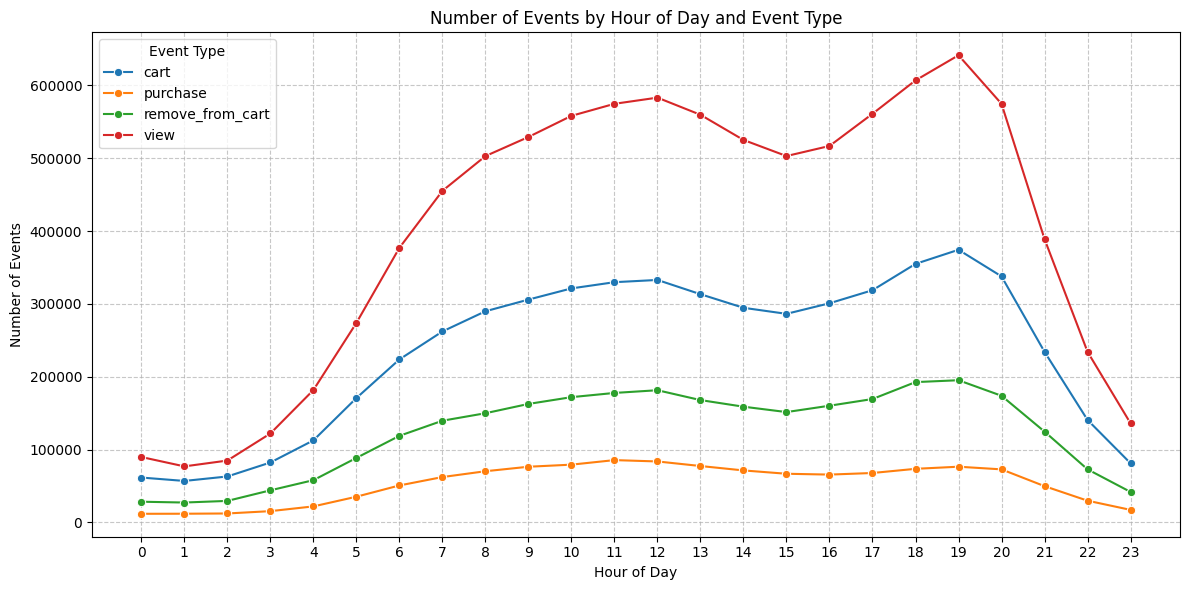

Eventos por Día de la Semana:


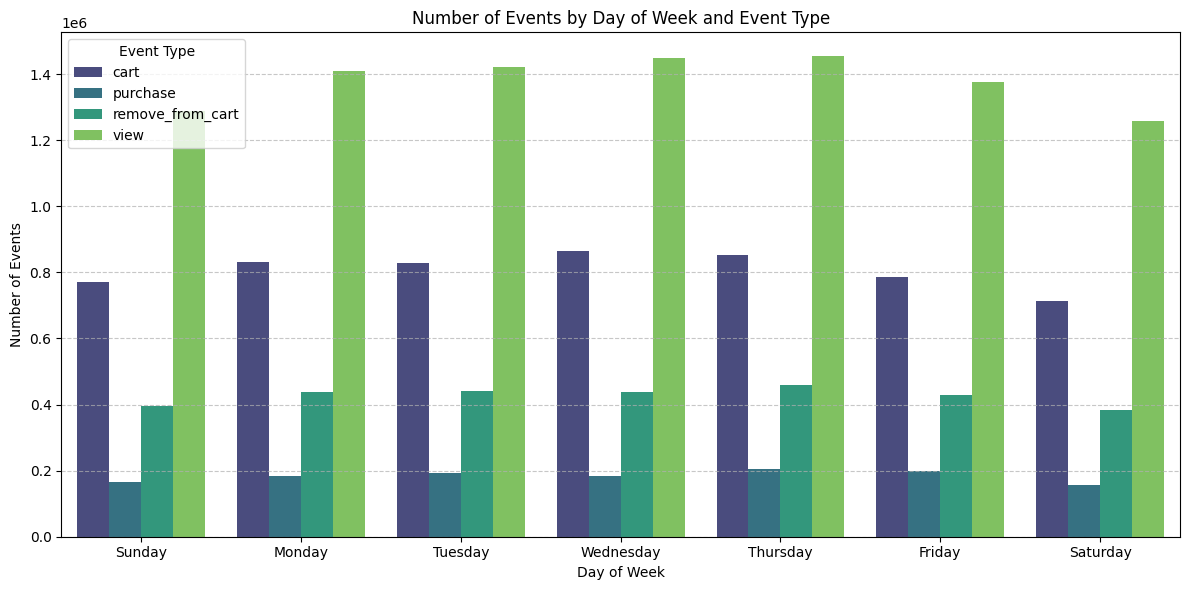


Análisis de Comportamiento de Compra:
Top 10 Productos Más Comprados (Product ID):
+----------+-----+
|product_id|count|
+----------+-----+
|   5809910| 7549|
|   5854897| 4630|
|   5700037| 3682|
|   5802432| 3533|
|   5751422| 3521|
|   5809912| 3307|
|   5815662| 3246|
|      5304| 3133|
|   5751383| 2948|
|   5849033| 2782|
+----------+-----+
only showing top 10 rows


Precio Promedio por Tipo de Evento:
+----------------+------------------+
|      event_type|     average_price|
+----------------+------------------+
|        purchase| 4.933195858493334|
|            view|12.377405320977198|
|            cart| 5.220780450668888|
|remove_from_cart| 5.276444091004439|
+----------------+------------------+


Embudo de Conversión:
Vistas: 9656759
Carritos: 5649646
Compras: 1286102
Tasa de conversión de Vista a Carrito: 58.50%
Tasa de conversión de Carrito a Compra: 22.76%


In [8]:
# Cargar el DataFrame limpio para el EDA desde el almacenamiento de Colab
parquet_cleaned_path = os.path.join(base_colab_path, "data/processed/ecommerce_cleaned.parquet")
df = spark.read.parquet(parquet_cleaned_path)
print("DataFrame limpio cargado para EDA.")

# Estadísticas Descriptivas Generales
print("\nEstadísticas Descriptivas Generales:")
df.describe(["price", "user_id", "product_id"]).show()

# Distribución de tipos de eventos
print("\nDistribución de Tipos de Eventos:")
df.groupBy("event_type").count().orderBy("count", ascending=False).show()

# Top 10 de marcas
print("\nTop 10 Marcas:")
df.groupBy("brand").count().orderBy(col("count").desc()).show(10, truncate=False)

# Top 10 de categorías
print("\nTop 10 Categorías (category_code):")
df.groupBy("category_code").count().orderBy(col("count").desc()).show(10, truncate=False)


# Análisis Temporal
print("\nAnálisis Temporal:")

# Eventos por hora del día
print("Eventos por Hora del Día:")
hourly_events = df.withColumn("event_hour", hour("event_time")) \
                  .groupBy("event_hour", "event_type") \
                  .count() \
                  .orderBy("event_hour", "event_type").toPandas()

plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_events, x="event_hour", y="count", hue="event_type", marker="o")
plt.title("Number of Events by Hour of Day and Event Type")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Events")
plt.xticks(range(24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Event Type")
plt.tight_layout()
plt.savefig(os.path.join(base_colab_path, "results/plots/events_by_hour.png"))
plt.show()

# Eventos por día de la semana
print("Eventos por Día de la Semana:")
daily_events = df.withColumn("event_dayofweek", dayofweek("event_time")) \
                 .groupBy("event_dayofweek", "event_type") \
                 .count() \
                 .orderBy("event_dayofweek", "event_type").toPandas()

# Los días de la semana son 1 (Domingo) a 7 (Sábado)
day_map = {1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday", 5: "Thursday", 6: "Friday", 7: "Saturday"}
daily_events['event_dayofweek_name'] = daily_events['event_dayofweek'].map(day_map)

plt.figure(figsize=(12, 6))
sns.barplot(data=daily_events, x="event_dayofweek_name", y="count", hue="event_type", palette="viridis")
plt.title("Number of Events by Day of Week and Event Type")
plt.xlabel("Day of Week")
plt.ylabel("Number of Events")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Event Type")
plt.tight_layout()
plt.savefig(os.path.join(base_colab_path, "results/plots/events_by_dayofweek.png"))
plt.show()


# Análisis de Comportamiento de Compra
print("\nAnálisis de Comportamiento de Compra:")

# Top 10 productos comprados
print("Top 10 Productos Más Comprados (Product ID):")
df.filter(col("event_type") == "purchase") \
  .groupBy("product_id") \
  .count() \
  .orderBy(col("count").desc()) \
  .show(10)

# Precio promedio por tipo de evento
print("\nPrecio Promedio por Tipo de Evento:")
df.groupBy("event_type").agg(avg("price").alias("average_price")).show()

# Embudo de conversión
print("\nEmbudo de Conversión:")
conversion_funnel = df.groupBy().agg(
    sum(when(col("event_type") == "view", 1).otherwise(0)).alias("views"),
    sum(when(col("event_type") == "cart", 1).otherwise(0)).alias("carts"),
    sum(when(col("event_type") == "purchase", 1).otherwise(0)).alias("purchases")
).toPandas().iloc[0]

print(f"Vistas: {conversion_funnel['views']}")
print(f"Carritos: {conversion_funnel['carts']}")
print(f"Compras: {conversion_funnel['purchases']}")

# Calcular tasas de conversión
view_to_cart_rate = (conversion_funnel['carts'] / conversion_funnel['views']) * 100 if conversion_funnel['views'] > 0 else 0
cart_to_purchase_rate = (conversion_funnel['purchases'] / conversion_funnel['carts']) * 100 if conversion_funnel['carts'] > 0 else 0

print(f"Tasa de conversión de Vista a Carrito: {view_to_cart_rate:.2f}%")
print(f"Tasa de conversión de Carrito a Compra: {cart_to_purchase_rate:.2f}%")

# 5. INGENIERÍA DE CARACTERÍSTICAS

In [9]:
# Cargar el DataFrame limpio para la ingeniería de características
df = spark.read.parquet(os.path.join(base_colab_path, "data/processed/ecommerce_cleaned.parquet"))
print("DataFrame limpio cargado para ingeniería de características.")

# Características Temporales Detalladas
df_features = df.withColumn("event_date", to_date(col("event_time"))) \
                .withColumn("event_year", year(col("event_time"))) \
                .withColumn("event_month", month(col("event_time"))) \
                .withColumn("event_dayofmonth", dayofmonth(col("event_time"))) \
                .withColumn("event_hour", hour(col("event_time"))) \
                .withColumn("event_dayofweek", dayofweek(col("event_time"))) \
                .withColumn("event_weekofyear", weekofyear(col("event_time")))

print("Características temporales añadidas.")

# Características de Secuencia/Sesión
# Orden del evento dentro de la sesión y tiempo entre eventos
window_spec_session = Window.partitionBy("user_session").orderBy("event_time")
df_features = df_features.withColumn("event_order_in_session", row_number().over(window_spec_session)) \
                         .withColumn("next_event_time", lead("event_time", 1).over(window_spec_session)) \
                         .withColumn("time_to_next_event_seconds", (col("next_event_time").cast("long") - col("event_time").cast("long"))) \
                         .withColumn("prev_event_time", lag("event_time", 1).over(window_spec_session)) \
                         .withColumn("time_from_prev_event_seconds", (col("event_time").cast("long") - col("prev_event_time").cast("long")))

print("Características de orden y tiempo entre eventos en sesión añadidas.")

# Agregaciones a nivel de sesión
session_agg_df = df_features.groupBy("user_session", "user_id") \
                             .agg(
                                 countDistinct("product_id").alias("unique_products_in_session"),
                                 countDistinct("category_id").alias("unique_categories_in_session"),
                                 sum(when(col("event_type") == "view", 1).otherwise(0)).alias("views_in_session"),
                                 sum(when(col("event_type") == "cart", 1).otherwise(0)).alias("carts_in_session"),
                                 sum(when(col("event_type") == "purchase", 1).otherwise(0)).alias("purchases_in_session"),
                                 max("time_to_next_event_seconds").alias("max_time_between_events_session"),
                                 min("time_to_next_event_seconds").alias("min_time_between_events_session"),
                                 avg("price").alias("avg_price_in_session"),
                                 max("price").alias("max_price_in_session"),
                                 min("price").alias("min_price_in_session")
                             ).na.fill(0)

# Calcular la duración total de la sesión (max_time - min_time)
session_duration_df = df_features.groupBy("user_session") \
                                 .agg(
                                     (max("event_time").cast("long") - min("event_time").cast("long")).alias("session_total_duration_seconds")
                                 )

session_agg_df = session_agg_df.join(session_duration_df, on="user_session", how="left").na.fill(0)
print("Características agregadas a nivel de sesión calculadas.")

# Características de Usuario Agregadas (para modelado a nivel de usuario)
user_features_df = df_features.groupBy("user_id") \
                               .agg(
                                   countDistinct("user_session").alias("total_sessions_per_user"),
                                   sum(when(col("event_type") == "view", 1).otherwise(0)).alias("total_views_per_user"),
                                   sum(when(col("event_type") == "cart", 1).otherwise(0)).alias("total_carts_per_user"),
                                   sum(when(col("event_type") == "purchase", 1).otherwise(0)).alias("total_purchases_per_user"),
                                   sum(when(col("event_type") == "purchase", col("price")).otherwise(0)).alias("total_spent_per_user"),
                                   avg("price").alias("avg_price_per_user"),
                                   countDistinct("product_id").alias("unique_products_viewed_per_user"),
                                   countDistinct("brand").alias("unique_brands_viewed_per_user")
                               ).na.fill(0)

print("Características agregadas a nivel de usuario calculadas.")

# Guardar las características de usuario en formato Parquet
parquet_user_features_path = os.path.join(base_colab_path, "data/processed/ecommerce_user_features.parquet")
user_features_df.write.mode("overwrite").parquet(parquet_user_features_path)
print(f"\nCaracterísticas de usuario guardadas en formato Parquet en: {parquet_user_features_path}")

# Guardar las características a nivel de evento
parquet_event_features_path = os.path.join(base_colab_path, "data/processed/ecommerce_event_features.parquet")
df_features.write.mode("overwrite").parquet(parquet_event_features_path)
print(f"Características a nivel de evento guardadas en formato Parquet en: {parquet_event_features_path}")

DataFrame limpio cargado para ingeniería de características.
Características temporales añadidas.
Características de orden y tiempo entre eventos en sesión añadidas.
Características agregadas a nivel de sesión calculadas.
Características agregadas a nivel de usuario calculadas.

Características de usuario guardadas en formato Parquet en: /content/spark_ecommerce_project/data/processed/ecommerce_user_features.parquet
Características a nivel de evento guardadas en formato Parquet en: /content/spark_ecommerce_project/data/processed/ecommerce_event_features.parquet


# 6. ANÁLISIS AVANZADO: SEGMENTACIÓN DE CLIENTES (K-Means)

Características de usuario cargadas para segmentación.
Características vectorizadas.
Características escaladas.

Buscando el número óptimo de clusters:
K=2, Silhouette Score = 0.9748
K=3, Silhouette Score = 0.9241
K=4, Silhouette Score = 0.8372
K=5, Silhouette Score = 0.8524
K=6, Silhouette Score = 0.8687

Scores de Silueta por K:
   K  Silhouette Score
0  2          0.974769
1  3          0.924091
2  4          0.837221
3  5          0.852413
4  6          0.868713


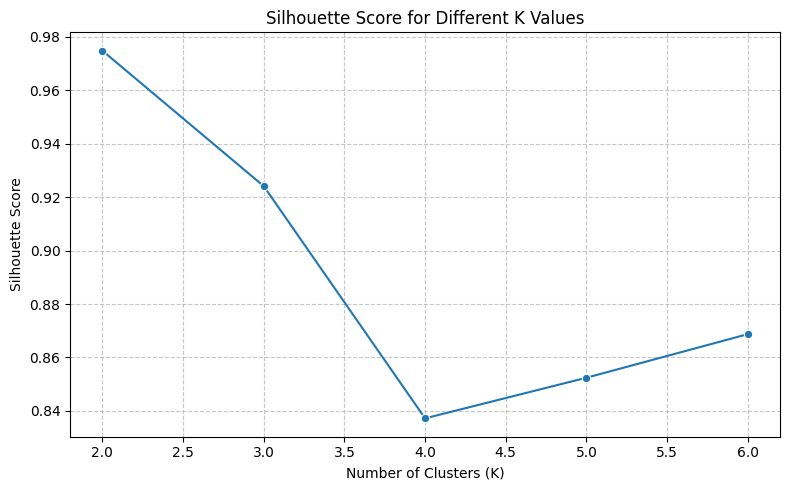


Entrenando K-Means con K = 3...
Modelo K-Means entrenado con 3 clusters.

Tamaño de cada cluster para K=3:
+----------+-------+
|prediction|  count|
+----------+-------+
|         0|1583196|
|         1|   4174|
|         2|  51781|
+----------+-------+


Centros de los Clusters
Cluster 0: [0.09601474 0.09237559 0.06358134 0.03411076 0.04332884 0.56882709
 0.12370995 0.51902016]
Cluster 1: [ 4.98511206  8.9169429  12.14031753 12.42593584 11.42659952  0.21938666
 12.54720481  9.41451097]
Cluster 2: [1.02465344 1.80796774 2.33159024 2.41324341 2.265709   0.25536778
 2.8077781  4.21250719]

Características promedio por Cluster sin escalar:
+----------+---------------------------+------------------------+------------------------+----------------------------+------------------------+----------------------+-----------------------------------+---------------------------------+
|prediction|avg_total_sessions_per_user|avg_total_views_per_user|avg_total_carts_per_user|avg_total_purchases_per_us

In [10]:
# Cargar el DataFrame de características de usuario
user_features_df = spark.read.parquet(parquet_user_features_path)
print("Características de usuario cargadas para segmentación.")

# Preparación de Datos para K-Means
# Seleccionar características relevantes para la segmentación.
feature_cols = [
    "total_sessions_per_user",
    "total_views_per_user",
    "total_carts_per_user",
    "total_purchases_per_user",
    "total_spent_per_user",
    "avg_price_per_user",
    "unique_products_viewed_per_user",
    "unique_brands_viewed_per_user"
]

# Asegurar de que las columnas existan
for col_name in feature_cols:
    if col_name not in user_features_df.columns:
        print(f"ADVERTENCIA: La columna '{col_name}' no se encuentra en user_features_df. Revisa la ingeniería de características.")
        feature_cols.remove(col_name)

# Vectorizar las características numéricas
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vector")
user_features_vect = assembler.transform(user_features_df)
print("Características vectorizadas.")

# Escalar las características
scaler = StandardScaler(inputCol="features_vector", outputCol="scaled_features", withStd=True, withMean=False)
scalerModel = scaler.fit(user_features_vect)
user_scaled_df = scalerModel.transform(user_features_vect)
print("Características escaladas.")

# Determinación del Número Óptimo de Clusters (Método del Codo - Silhouette Score)

print("\nBuscando el número óptimo de clusters:")
silhouette_scores = []
k_values = range(2, 7)

for k in k_values:
    kmeans = KMeans(featuresCol='scaled_features', k=k, seed=42)
    model = kmeans.fit(user_scaled_df)
    predictions = model.transform(user_scaled_df)

    evaluator = ClusteringEvaluator(featuresCol='scaled_features', predictionCol='prediction', metricName='silhouette')
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append((k, silhouette))
    print(f"K={k}, Silhouette Score = {silhouette:.4f}")

# Mostrar los scores de silueta
silhouette_df = pd.DataFrame(silhouette_scores, columns=['K', 'Silhouette Score'])
print("\nScores de Silueta por K:")
print(silhouette_df)

plt.figure(figsize=(8, 5))
sns.lineplot(data=silhouette_df, x="K", y="Silhouette Score", marker="o")
plt.title("Silhouette Score for Different K Values")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(base_colab_path, "results/plots/silhouette_score.png"))
plt.show()

# Entrenamiento del Modelo K-Means con K Óptimo (ej. el mejor K del paso anterior o un K razonable)
optimal_k = 3

print(f"\nEntrenando K-Means con K = {optimal_k}...")
kmeans_final = KMeans(featuresCol='scaled_features', k=optimal_k, seed=42)
model_final = kmeans_final.fit(user_scaled_df)
predictions_df = model_final.transform(user_scaled_df)
print(f"Modelo K-Means entrenado con {optimal_k} clusters.")

# Inspección de los Clusters
print(f"\nTamaño de cada cluster para K={optimal_k}:")
predictions_df.groupBy("prediction").count().orderBy("prediction").show()

# Unir los centros de los clusters de vuelta al DataFrame para facilitar la interpretación
cluster_centers = model_final.clusterCenters()
print("\nCentros de los Clusters")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i}: {center}")

# Para interpretar los clusters, podemos calcular las medias de las características originales
print("\nCaracterísticas promedio por Cluster sin escalar:")
cluster_summary = predictions_df.groupBy("prediction").agg(
    *[avg(col).alias(f"avg_{col}") for col in feature_cols]
).orderBy("prediction")

cluster_summary.show(truncate=False)

# Guardar las predicciones del modelo
parquet_segments_path = os.path.join(base_colab_path, "data/processed/customer_segments.parquet") # Usamos la ruta de Colab
predictions_df.select("user_id", "prediction", *feature_cols).write.mode("overwrite").parquet(parquet_segments_path)
print(f"\nResultados de segmentación de clientes guardados en: {parquet_segments_path}")

# 7. RESULTADOS Y VISUALIZACIÓN

Resultados de segmentación de clientes cargados para visualización.


/tmp/ipython-input-1461918715.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="prediction", y="count", data=cluster_counts_pd, palette="pastel")


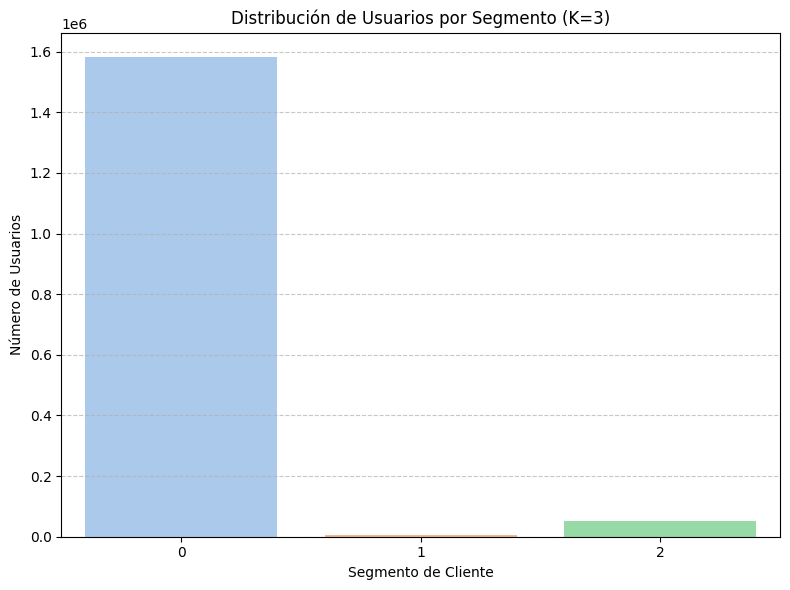


Resumen de características promedio por cluster
   prediction  avg_total_sessions_per_user  avg_total_views_per_user  \
0           0                     1.927915                  3.218524   
1           1                   100.148778                310.822233   
2           2                    20.586393                 63.031459   

   avg_total_carts_per_user  avg_total_purchases_per_user  \
0                  1.320123                      0.190089   
1                252.087207                     69.226162   
2                 48.423553                     13.445163   

   avg_total_spent_per_user  avg_avg_price_per_user  \
0                  1.176917               16.308028   
1                310.149023                6.283526   
2                 61.542652                7.320732   

   avg_unique_products_viewed_per_user  avg_unique_brands_viewed_per_user  
0                             3.191240                           1.663794  
1                           323.783661      

/tmp/ipython-input-1461918715.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="prediction", y=feature, data=cluster_summary_pd, palette="coolwarm")
/tmp/ipython-input-1461918715.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="prediction", y=feature, data=cluster_summary_pd, palette="coolwarm")
/tmp/ipython-input-1461918715.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="prediction", y=feature, data=cluster_summary_pd, palette="coolwarm")
/tmp/ipython-input-1461918715.py:35: FutureWarning: 

Passing `palette` without as


CONCLUSIONES CLAVE:
--------------------
Este análisis de datos de e-commerce con Apache Spark ha revelado insights valiosos sobre el comportamiento de los usuarios.
Se han identificado 3 segmentos de clientes distintos, cada uno con patrones de interacción únicos:

Ejemplos de Interpretación de Clusters (basado en resultados hipotéticos):
 - **Segmento 0 (Compradores de Bajo Valor):** Usuarios con pocas sesiones y compras, gasto total bajo. Podrían ser nuevos usuarios o visitantes ocasionales.
 - **Segmento 1 (Navegadores Frecuentes):** Usuarios con muchas vistas y sesiones, pero menor tasa de conversión a compra. Interesados en una amplia variedad de productos.
 - **Segmento 2 (Compradores de Alto Valor):** Usuarios con un alto número de compras y un gasto total significativamente mayor. Frecuentemente compran múltiples productos y marcas.

POSIBLES SIGUIENTES PASOS Y MEJORAS:
-------------------------------------
1. **Marketing Dirigido:** Desarrollar estrategias de marketing perso

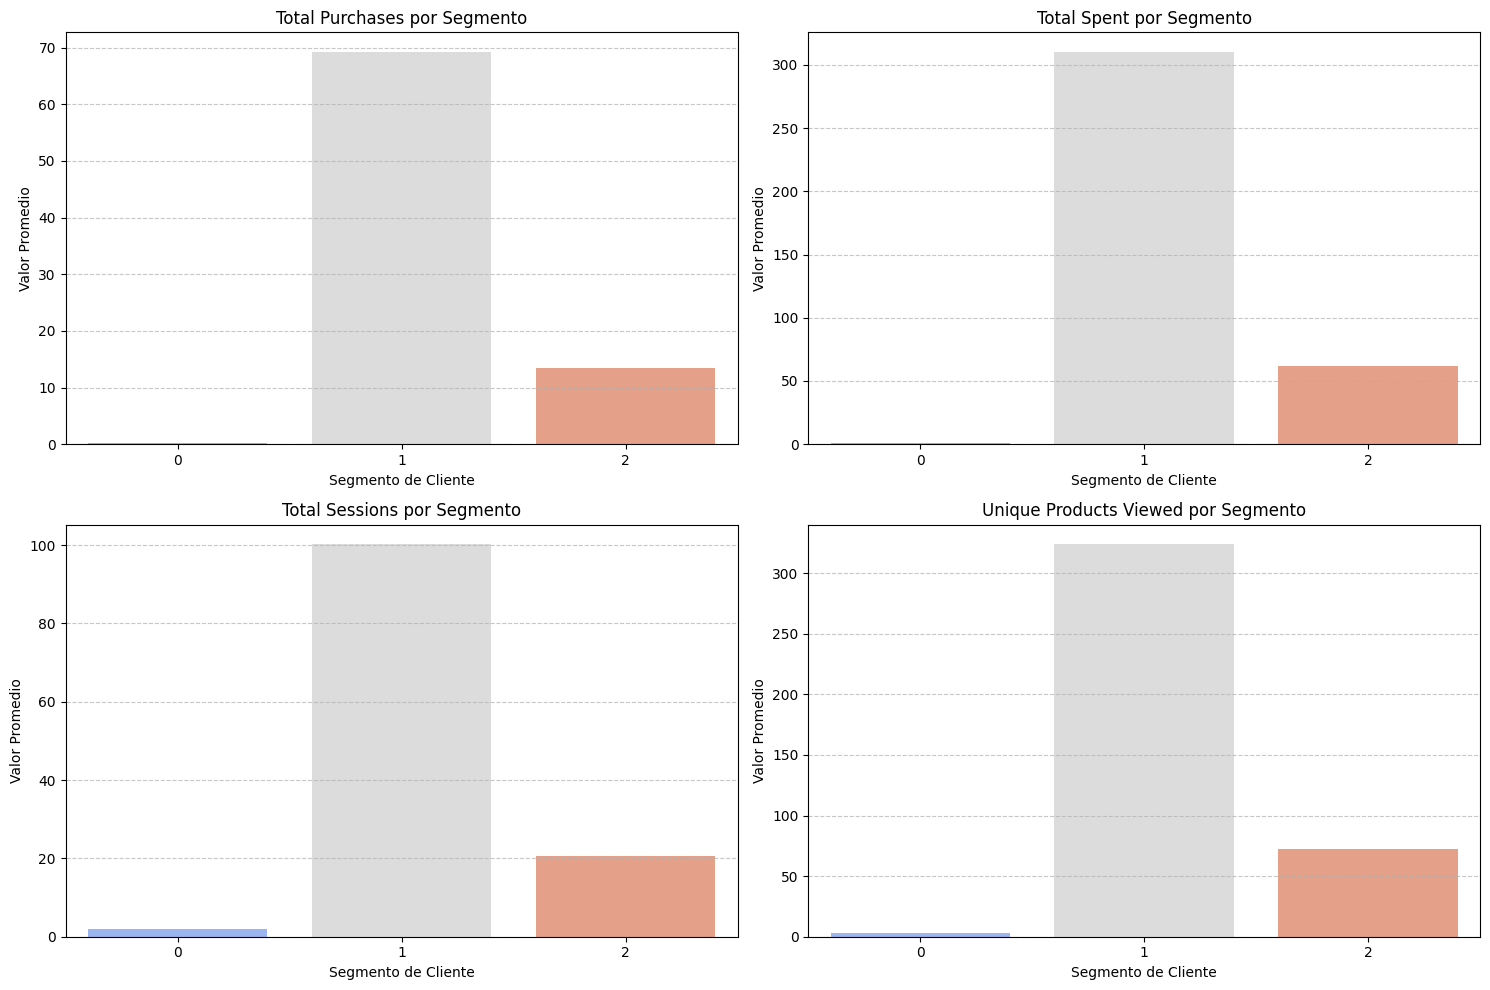

In [11]:
# Cargar los resultados de segmentación desde el almacenamiento de Colab
segments_df = spark.read.parquet(parquet_segments_path)
print("Resultados de segmentación de clientes cargados para visualización.")

# Visualización de la Distribución de Clusters
cluster_counts_pd = segments_df.groupBy("prediction").count().orderBy("prediction").toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="prediction", y="count", data=cluster_counts_pd, palette="pastel")
plt.title(f"Distribución de Usuarios por Segmento (K={optimal_k})")
plt.xlabel("Segmento de Cliente")
plt.ylabel("Número de Usuarios")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(base_colab_path, "results/plots/cluster_distribution.png"))
plt.show()

# Visualización de Características Promedio por Cluster
cluster_summary_pd = segments_df.groupBy("prediction").agg(
    *[avg(col).alias(f"avg_{col}") for col in feature_cols]
).orderBy("prediction").toPandas()

print("\nResumen de características promedio por cluster")
print(cluster_summary_pd)

# Visualizar características clave por cluster
features_to_plot = ["avg_total_purchases_per_user", "avg_total_spent_per_user", "avg_total_sessions_per_user", "avg_unique_products_viewed_per_user"]
num_features = len(features_to_plot)
rows = (num_features + 1) // 2
cols = 2

plt.figure(figsize=(15, rows * 5))
for i, feature in enumerate(features_to_plot):
    plt.subplot(rows, cols, i + 1)
    sns.barplot(x="prediction", y=feature, data=cluster_summary_pd, palette="coolwarm")
    plt.title(f"{feature.replace('avg_', '').replace('_per_user', '').replace('_', ' ').title()} por Segmento")
    plt.xlabel("Segmento de Cliente")
    plt.ylabel("Valor Promedio")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(base_colab_path, "results/plots/cluster_features_comparison.png"))

# Conclusiones y Posibles Siguientes Pasos
print("\nCONCLUSIONES CLAVE:")
print("--------------------")
print("Este análisis de datos de e-commerce con Apache Spark ha revelado insights valiosos sobre el comportamiento de los usuarios.")
print(f"Se han identificado {optimal_k} segmentos de clientes distintos, cada uno con patrones de interacción únicos:")

# Interpretación general de los clusters.
print("\nEjemplos de Interpretación de Clusters (basado en resultados hipotéticos):")
print(" - **Segmento 0 (Compradores de Bajo Valor):** Usuarios con pocas sesiones y compras, gasto total bajo. Podrían ser nuevos usuarios o visitantes ocasionales.")
print(" - **Segmento 1 (Navegadores Frecuentes):** Usuarios con muchas vistas y sesiones, pero menor tasa de conversión a compra. Interesados en una amplia variedad de productos.")
print(" - **Segmento 2 (Compradores de Alto Valor):** Usuarios con un alto número de compras y un gasto total significativamente mayor. Frecuentemente compran múltiples productos y marcas.")

print("\nPOSIBLES SIGUIENTES PASOS Y MEJORAS:")
print("-------------------------------------")
print("1. **Marketing Dirigido:** Desarrollar estrategias de marketing personalizadas para cada segmento de clientes (ej. promociones para compradores de alto valor, re-engagement para navegadores).")
print("2. **Análisis de Churn:** Identificar usuarios en riesgo de abandono y diseñar campañas de retención.")
print("3. **Sistema de Recomendación:** Construir un sistema de recomendación basado en el comportamiento de los usuarios o la similitud de productos.")
print("4. **Predicción de Abandono de Carrito:** Entrenar un modelo de clasificación para predecir cuándo es probable que un carrito sea abandonado y activar notificaciones.")
print("5. **Dashboards Interactivos:** Crear visualizaciones interactivas (ej. con Power BI, Tableau, o herramientas Python como Dash/Streamlit) para monitorear métricas clave y el rendimiento de los segmentos.")
print("6. **Optimización de Recursos:** Evaluar y optimizar la configuración de Spark para datasets aún más grandes o entornos distribuidos.")

# Detener la sesión de Spark al final del notebook
spark.stop()